In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import pystan
import experiments
import utils

In [2]:
import itertools
import pandas as pd
import utils
import experiments

In [3]:
rawdf = pd.read_json("PICO-annos-crowdsourcing.json", lines=True)
aggdf = pd.read_json("PICO-annos-crowdsourcing-agg.json", lines=True)
golddf = pd.read_json("PICO-annos-professional.json", lines=True)

In [4]:
userIDs = []
itemIDs = []
labels = []
golds = []
hmmcrowds = []
dawidskenes = []
majorityvotes = []
for row in rawdf.iterrows():
    itemID = row[1]["docid"]
    data = row[1]["Participants"]
    gold = golddf[golddf["docid"] == itemID]["Participants"].values[0]
    gold = gold.get("MedicalStudent")
    agg = aggdf[aggdf["docid"] == itemID]["Participants"].values[0]
    for userID, label in data.items():
        userIDs.append(userID)
        itemIDs.append(itemID)
        labels.append(label)
        golds.append(gold)
        hmmcrowds.append(agg["HMMCrowd"])
        dawidskenes.append(agg["DawidSkene"])
        majorityvotes.append(agg["MajorityVote"])
df = pd.DataFrame({"uid":userIDs, "itemID":itemIDs, "label":labels, "gold":golds,
                  "HMMCrowd":hmmcrowds, "DawidSkene":dawidskenes, "MajorityVote":majorityvotes})
df = df.sort_values("itemID")
userIdDict = utils.make_categorical(df, "uid")
itemIdDict = utils.make_categorical(df, "itemID")

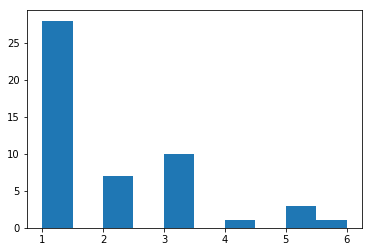

In [5]:
plt.hist(np.random.geometric(0.5, 50))
plt.show()

In [6]:
df.shape

(1165, 7)

In [7]:
gold_labels = dict(df.groupby("itemID").first()["gold"].dropna())
hmm_labels = dict(df.groupby("itemID").first()["HMMCrowd"].dropna())
ds_labels = dict(df.groupby("itemID").first()["DawidSkene"].dropna())
mv_labels = dict(df.groupby("itemID").first()["MajorityVote"].dropna())

In [8]:
len(gold_labels)

188

In [9]:
def labels2set(labels):
    ranges = [range(s[0], s[1]+1) for s in labels]
    return set(itertools.chain.from_iterable(ranges))

def list2ranges(i):
    result = []
    for a, b in itertools.groupby(enumerate(i), lambda k: k[1] - k[0]):
        b = list(b)
        result.append([b[0][1], b[-1][1]])
    return result

def intersects_per_span(a_spans, b_spans):
    a_sets = [labels2set([a]) for a in a_spans]
    b_set = labels2set(b_spans)
    scores = [len(a.intersection(b_set)) / len(a) for a in a_sets]
    return np.mean(scores)

def eval_precision(pred_spans, gold_spans):
    return intersects_per_span(pred_spans, gold_spans)

def eval_recall(pred_spans, gold_spans):
    return intersects_per_span(gold_spans, pred_spans)

def eval_f1(a_spans, b_spans):
    p = eval_precision(a_spans, b_spans)
    r = eval_precision(b_spans, a_spans)
    denom = (p + r)
    return 2 * p * r / denom if denom > 0 else 0

In [10]:
pd.set_option('display.max_colwidth', 800)

In [11]:
pd.set_option('display.width', 2000)
df.sort_values("itemID")[["label"]]

,label
1105,"[[568, 580]]"
1104,"[[21, 44], [67, 76], [362, 421], [568, 580]]"
1103,"[[67, 147]]"
1102,"[[5, 44], [61, 135], [253, 294], [362, 421], [568, 580], [659, 859], [1103, 1123]]"
1101,"[[5, 17], [395, 401]]"
1100,"[[568, 580]]"
1099,"[[21, 44], [271, 294], [362, 421], [568, 580], [1103, 1123]]"
561,"[[60, 112], [510, 518], [313, 321], [617, 625]]"
562,"[[0, 60], [60, 769]]"
563,"[[19, 25], [510, 518], [66, 73]]"


In [12]:
stan_data = utils.calc_distances(df, lambda x, y: 1 - eval_f1(x, y), "label", "itemID")

100%|██████████| 191/191 [00:03<00:00, 55.61it/s]


In [13]:
stan_data

{'items': array([  1,   1,   1, ..., 191, 191, 191]),
 'u1s': array([35, 35, 35, ..., 14, 14, 35]),
 'u2s': array([28, 14, 80, ..., 35, 84, 84]),
 'distances': array([0.7       , 1.1       , 0.85      , ..., 0.1       , 0.90645161,
        0.90645161]),
 'NDATA': 3108,
 'NITEMS': 191,
 'NUSERS': 91,
 'n_gold_users': 0,
 'gold_user_err': 0}

In [14]:
# stan_model = utils.stanmodel("mas", overwrite=True)

In [15]:

# stan_data["use_diff"] = 0
# stan_data["use_disc"] = 1
# stan_data["use_norm"] = 1
# stan_data["norm_ratio"] = 0.5
# stan_data["norm_ratio"] = 1
# stan_data["eps_limit"] = 1
# stan_data["eps_limit"] = 3
# stan_data["uerr_prior_scale"] = 1
# stan_data["diff_prior_scale"] = 1
# stan_data["disc_prior_scale"] = 1
# stan_data["DIM_SIZE"] = 8
# stan_data["DIM_SIZE"] = 8
# stan_data["err_scale"] = 0.1
# opt = stan_model.optimizing(data=stan_data,verbose=True,iter=1500)

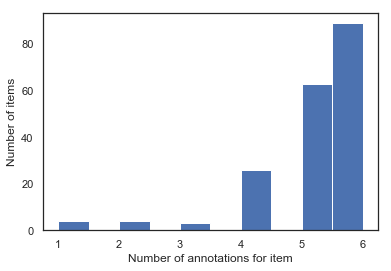

In [33]:
plt.rcParams.update({'font.size': 20})
sddf = pd.DataFrame(stan_data)
n1 = sddf.groupby(["u1s", "items"]).count()["distances"].groupby("items").count()
plt.hist(n1)
plt.xlabel("Number of annotations for item")
plt.ylabel("Number of items")
plt.show()


In [14]:
# n1.median()

In [15]:
# (n1.values / 191).mean()

In [16]:
stan_data["NUSERS"], stan_data["NITEMS"]

(91, 191)

In [17]:
# opt["uerr_prior_loc"], opt["diff_prior_loc"]

In [19]:
plt.rcParams.update({'font.size': 20})

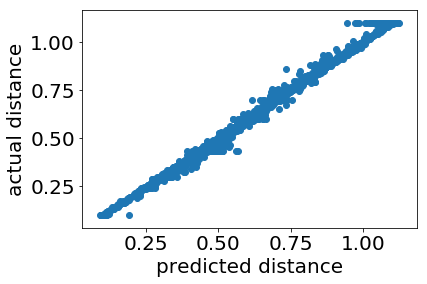

In [20]:
# plt.scatter(opt["pred_distances"], stan_data["distances"])
# plt.xlabel("predicted distance")
# plt.ylabel("actual distance")
# # plt.title("Fit Diagnostic")
# plt.show()

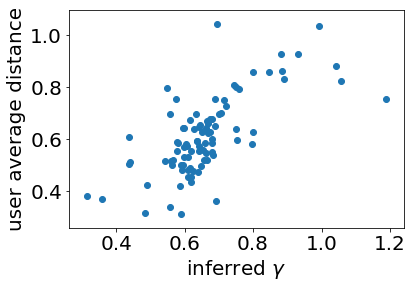

In [21]:
uerr_b = experiments.uerr_baseline(stan_data)
plt.scatter(opt["uerr"], uerr_b)
plt.xlabel("inferred $\gamma$")
plt.ylabel("user average distance")
# plt.title("User Diagnostic")
plt.show()

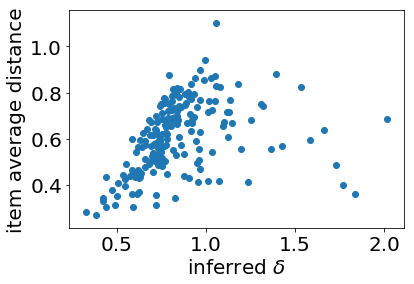

In [22]:
diff_b = sddf.groupby("items").mean()["distances"].to_dict()
diff_m = dict([(i+1, v) for i, v in enumerate(opt["disc"]) if i+1 in diff_b.keys()])
plt.scatter(diff_m.values(), diff_b.values())
plt.xlabel("inferred $\delta$")
plt.ylabel("item average distance")
# plt.title("Item Diagnostic")
plt.show()

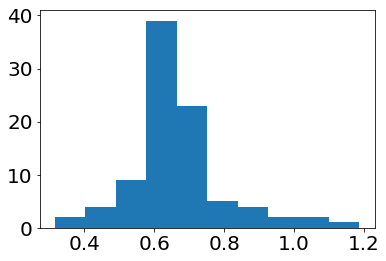

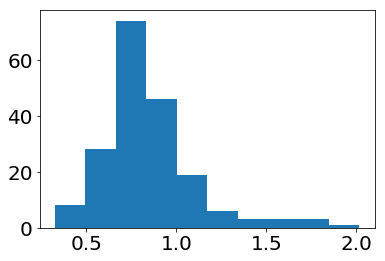

In [23]:
plt.hist(opt["uerr"])
plt.show()
plt.hist(opt["disc"])
plt.show()

In [18]:
# per_item_user_rankings = experiments.get_model_user_rankings(opt, debug=True)

In [19]:
# uerr_penalties = dict(enumerate(opt["uerr"]))
# idiff_penalties = dict(enumerate(opt["diff"]))

In [20]:
# experiments.run_square(df, "uid", "itemID", "label")

In [21]:
# model4 = experiments.get_preds(df, per_item_user_rankings, "label", "itemID")

In [22]:
# model4

In [38]:
# random = experiments.get_baseline_random(df, "label", "itemID")
# faveu = experiments.get_baseline_global_best_user(stan_data, df, "label", "itemID")
# center = experiments.get_baseline_item_centrallest(stan_data, df, "label", "itemID")
# oracle = experiments.get_oracle_preds(stan_data, df, "label", "itemID", "uid", eval_f1, gold_labels)


In [23]:
# print("MAJORITY VOTE")
# experiments.eval_preds_vs(random, mv_labels, gold_labels, eval_f1)
# print("FAVORITE USER")
# experiments.eval_preds_vs(random, faveu, gold_labels, eval_f1)
# print("SMALLEST DISTANCE")
# experiments.eval_preds_vs(random, center, gold_labels, eval_f1)
# print("MULTIDIMENSIONAL SCALING")
# experiments.eval_preds_vs(random, model4, gold_labels, eval_f1)
# print("HMM")
# experiments.eval_preds_vs(random, hmm_labels, gold_labels, eval_f1)
# print("ORACLE")
# experiments.eval_preds_vs(random, oracle, gold_labels, eval_f1)

In [24]:
# experiments.eval_preds_vs(model4, hmm_labels, gold_labels, eval_f1)

# Experiments

In [16]:
sequence_experiment = experiments.RealExperiment(eval_f1, "label", "itemID", "uid")
sequence_experiment.annodf = df.copy()
sequence_experiment.golddict = gold_labels
sequence_experiment.produce_stan_data()
sequence_experiment.register_baseline("Tokenwise MV", mv_labels)
sequence_experiment.register_baseline("Crowd-HMM", hmm_labels)

100%|██████████| 191/191 [00:03<00:00, 60.60it/s]


In [17]:
sequence_experiment.describe()

91 & 191 & 1165 & 12.8$\pm$36.86 & 6.1$\pm$2.4 & 87


In [18]:
nsemisupervised = int(len(sequence_experiment.golddict) / 10)
experiments.set_supervised_items(sequence_experiment, nsemisupervised)

Pickled model loaded
sigma 0.02544739640157129


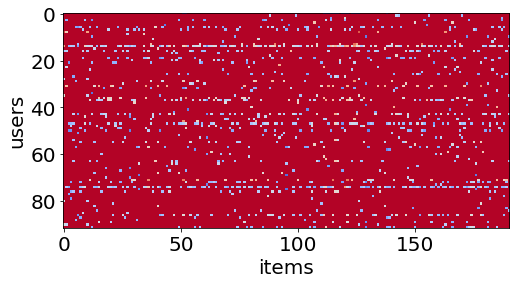

BEST AVAILABLE USER
0.5613001692998526 0.6766991025550481
t-test Ttest_relResult(statistic=-12.600687630009169, pvalue=1.694367444555958e-33)
z-score 0.4324544799252062
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.5613001692998526 0.6625224381096932
t-test Ttest_relResult(statistic=-11.577937651334938, pvalue=6.919335960627614e-29)
z-score 0.3973537915256511
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.5613001692998526 0.7198875694039887
t-test Ttest_relResult(statistic=-18.058181290071982, pvalue=6.1557516447725435e-62)
z-score 0.6197551774551439
baseline below thresh 0.0
model below thresh 0.0
Tokenwise MV
0.5613001692998526 0.6523847278367233
t-test Ttest_relResult(statistic=-10.889471825261317, pvalue=6.119753921465253e-26)
z-score 0.37372570554311424
baseline below thresh 0.0
model below thresh 0.0
Crowd-HMM
0.5613001692998526 0.7019480946626729
t-test Ttest_relResult(statistic=-16.425434682839597, pvalue=7.

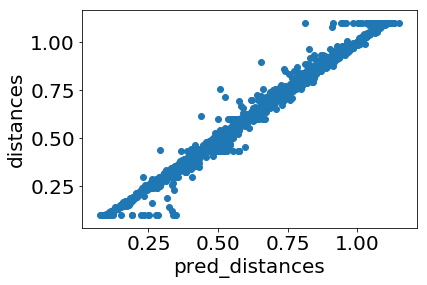

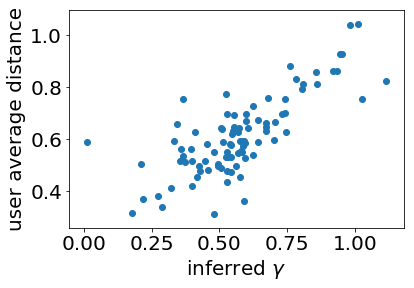

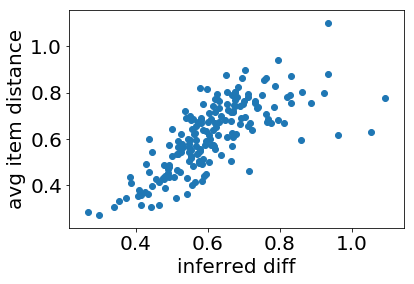

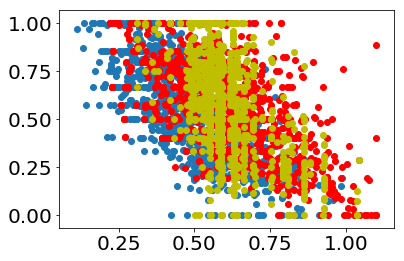


 ALL
ru 0 0.24834723075778278
bau -0.518593307712979 0.21339394212177715
sad -0.6304264993929569 0.19517380905983345
mas -0.6945601390077395 0.18033348170759753


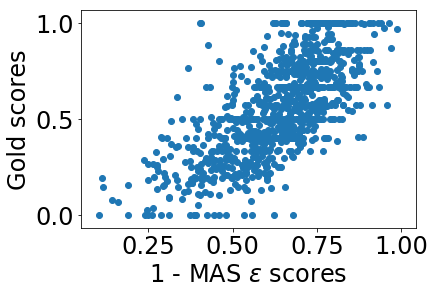

In [22]:
sequence_experiment.train(iter=1500)
sequence_experiment.test(debug=True)
sequence_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

100%|██████████| 191/191 [00:03<00:00, 58.05it/s]


Pickled model loaded
sigma 0.04126188815805963


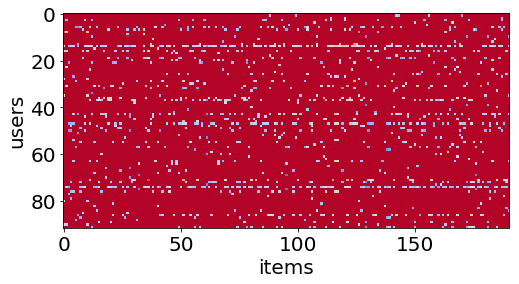

BEST AVAILABLE USER
0.5641031490445493 0.6766991025550481
t-test Ttest_relResult(statistic=-12.859500663903276, pvalue=1.0475710639252608e-34)
z-score 0.44133692025362015
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.5641031490445493 0.6625224381096932
t-test Ttest_relResult(statistic=-11.975983155292802, pvalue=1.1959743335601627e-30)
z-score 0.4110146778562282
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.5641031490445493 0.7068194658646266
t-test Ttest_relResult(statistic=-15.742440003856814, pvalue=3.481248510812143e-49)
z-score 0.5402791422595328
baseline below thresh 0.0
model below thresh 0.0
Tokenwise MV
0.5641031490445493 0.6523847278367233
t-test Ttest_relResult(statistic=-10.681935147092215, pvalue=4.4557828398066505e-25)
z-score 0.36660306518741814
baseline below thresh 0.0
model below thresh 0.0
Crowd-HMM
0.5641031490445493 0.7019480946626729
t-test Ttest_relResult(statistic=-15.55932159130007, pvalue=

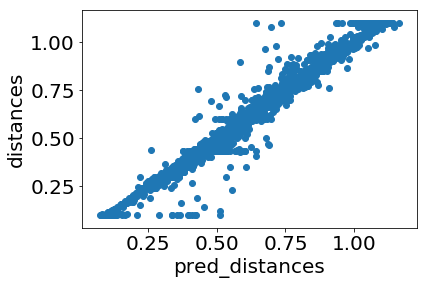

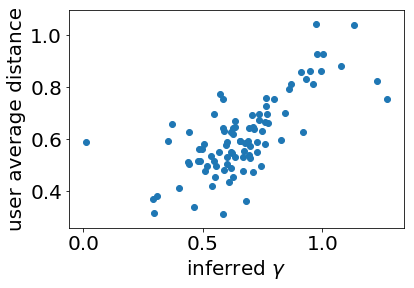

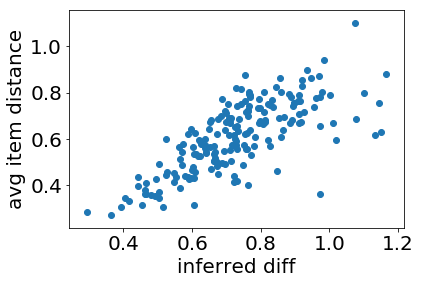

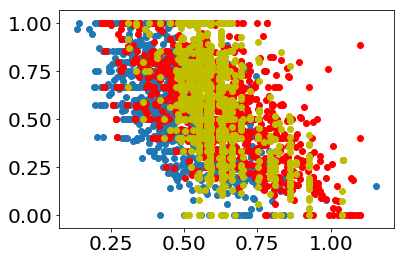


 ALL
ru 0 0.24834723075778278
bau -0.518593307712979 0.21339394212177715
sad -0.6304264993929569 0.19517380905983345
mas -0.5991866097304267 0.19926890487429338


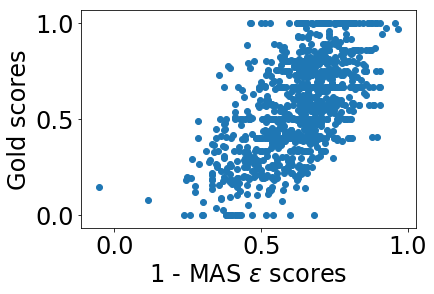

In [20]:
experiments.make_supervised_standata(sequence_experiment)
sequence_experiment.train(iter=1500, norm_ratio=1)
sequence_experiment.test(debug=True)
sequence_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

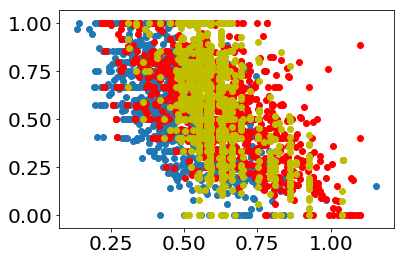


 ALL
ru 0 0.24834723075778278
bau -0.518593307712979 0.21339394212177715
sad -0.6304264993929569 0.19517380905983345
mas -0.5991866097304267 0.19926890487429338


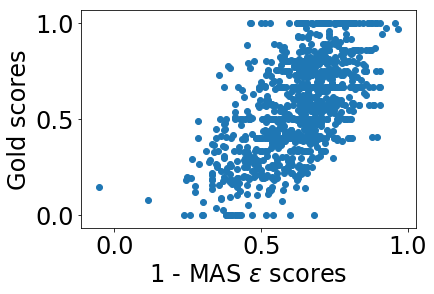

In [21]:
sequence_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

In [28]:
sequence_experiment.opt["dist_from_truth"]

array([[0.01282286, 0.25901448, 0.26587173, ..., 1.29376308, 0.60405414,
        1.29376308],
       [1.29376308, 1.29376308, 1.29376308, ..., 1.29376308, 0.4765224 ,
        1.29376308],
       [1.29376308, 1.29376308, 1.29376308, ..., 1.29376308, 1.29376308,
        1.29376308],
       ...,
       [1.29376308, 1.29376308, 1.29376308, ..., 1.29376308, 1.29376308,
        1.29376308],
       [1.29376308, 1.29376308, 1.29376308, ..., 1.29376308, 1.29376308,
        1.29376308],
       [1.29376308, 1.29376308, 1.29376308, ..., 1.29376308, 1.29376308,
        1.29376308]])

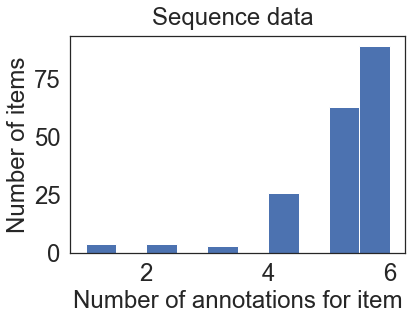

In [41]:
sddf = pd.DataFrame(sequence_experiment.stan_data)
n1 = sddf.groupby(["u1s", "items"]).count()["distances"].groupby("items").count()
fig, ax = plt.subplots()
plt.hist(n1)
fs = 24
fig.suptitle('Sequence data', fontsize=fs)
ax.set_xlabel("Number of annotations for item", fontsize=fs)
ax.set_ylabel("Number of items", fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.show()


In [557]:
chmm_preds = sequence_experiment.extra_baseline_labels["Crowd-HMM"]
chmm_scores = experiments.eval_preds(chmm_preds, sequence_experiment.golddict, sequence_experiment.eval_fn)
sequence_experiment.eval_model(chmm_scores, sequence_experiment.mas_preds, "", 1)


0.7019480946626728 0.7086944684850707
t-test Ttest_relResult(statistic=-0.47792337606210095, pvalue=0.6333223390227471)
z-score 0.03676333662016161
baseline below thresh 0.0
model below thresh 0.0


In [548]:
sequence_experiment.opt["uerr"]

array([0.01296244, 0.51179242, 0.50434389, 0.47621552, 1.11534853,
       0.39444149, 0.61405791, 0.60247164, 1.13382086, 0.72416177,
       0.53747632, 1.09023893, 0.70681454, 0.88730145, 0.75237396,
       1.04632335, 0.62158407, 0.82187481, 0.74421871, 0.51428733,
       0.73004449, 0.50872544, 0.59744848, 0.79868891, 0.66537789,
       0.56711244, 0.59385736, 0.50593142, 0.6005438 , 0.78787889,
       0.68061056, 1.01471605, 0.35248165, 0.59546609, 0.33974257,
       0.69113462, 0.87967477, 0.74996567, 0.9830975 , 0.60531481,
       0.96304341, 0.50817098, 0.35702891, 0.73127128, 0.66018752,
       0.5874353 , 0.94612351, 0.5950283 , 0.74051896, 0.6213147 ,
       0.48407176, 0.71114238, 0.55272935, 0.69933261, 0.68064951,
       0.69619748, 1.28485057, 0.62028367, 0.39694198, 0.96677381,
       0.82184217, 0.73564874, 0.71179006, 0.67940373, 0.94515492,
       0.5427786 , 0.50189256, 0.40387305, 0.84583954, 0.24665724,
       0.67121988, 1.01261153, 0.55493052, 0.61916693, 0.62284

In [549]:
sequence_experiment.opt["uerr_Z"]

array([-1.66733222e-04, -3.24136460e-01, -3.38797222e-01, -3.96185054e-01,
        4.54866646e-01, -5.84584759e-01, -1.41966336e-01, -1.61014974e-01,
        4.71292928e-01,  2.29592265e-02, -2.75170864e-01,  4.32096579e-01,
       -1.28725791e-03,  2.26129203e-01,  6.11779133e-02,  3.90982152e-01,
       -1.29784401e-01,  1.49532514e-01,  5.02793861e-02, -3.19273461e-01,
        3.10499014e-02, -3.30147108e-01, -1.69387515e-01,  1.20915945e-01,
       -6.17004364e-02, -2.21497991e-01, -1.75416422e-01, -3.35654440e-01,
       -1.64220005e-01,  1.07288807e-01, -3.90653025e-02,  3.60308519e-01,
       -6.97057022e-01, -1.72711124e-01, -7.33867401e-01, -2.37209577e-02,
        2.17496686e-01,  5.79718568e-02,  3.28652729e-01, -1.56306906e-01,
        3.08042916e-01, -3.31237607e-01, -6.84238815e-01,  3.27289219e-02,
       -6.95316539e-02, -1.86289471e-01,  2.90317544e-01, -1.73446603e-01,
        4.52956578e-02, -1.30217858e-01, -3.79822421e-01,  4.81708562e-03,
       -2.47187107e-01, -

In [550]:
sequence_experiment.opt["uerr_prior_loc"]

array(-0.3456997)

In [405]:
len(sequence_experiment.golddict)

188

In [473]:
sequence_experiment_SS = experiments.RealExperiment(eval_f1, "label", "itemID", "uid")
sequence_experiment_SS.annodf = df.copy()
sequence_experiment_SS.golddict = gold_labels
sequence_experiment_SS.register_baseline("Tokenwise MV", mv_labels)
sequence_experiment_SS.register_baseline("Crowd-HMM", hmm_labels)

In [474]:
sequence_experiment_SS.annodf.groupby("itemID").count()["label"].sort_values(ascending=False).index.values

array([  0, 138,  52, 111, 112, 113, 114, 115, 116, 117,  51, 119, 120,
       121, 123, 124, 125, 126, 127, 128, 129, 130,  49,  75, 134,  53,
       108, 107,  65,  79,  80,  81,  82,  84,  85,  70,  69,  68,  91,
        93, 106,  94,  62,  98,  60,  58, 101,  57,  56, 104,  55,  41,
        44, 165,  11, 139, 166, 167, 168,  14, 171, 172, 173,  12,  10,
       160,   7,   4, 181, 182, 183,   3, 185, 187,   1, 163,  74, 145,
        30,  37, 157, 140,  24,  27, 141, 152, 148, 151, 150,  36,  71,
        38,  19,  47,  67,   2,  42,  73,  72,  63,   6,  35,   9,  34,
        20,  61,  50,  13,  28,  21,  15,  16,  18,  40, 190,  76, 105,
       174, 153, 118, 122, 131, 132, 169, 164, 162, 161, 159, 137, 142,
        77, 156, 147, 149, 175, 110,  90,  92, 188,  83,  86,  87,  88,
        89, 177, 154, 184, 189, 180, 179, 178, 100,  17, 186, 158, 170,
        22,   8,  23,  25,  26, 176, 143,  29, 133,  78,  66,  64,  99,
        59,  54,  46,  45,  48, 144, 146,  32,  95, 103,  31,   

In [435]:
sequence_experiment_SS.train(iter=1500)

Pickled model loaded
sigma 0.015534836197168509


In [436]:
np.exp(sequence_experiment_SS.opt["disc_prior_loc"])

0.680057219138869

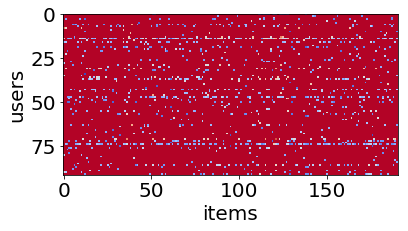

BEST AVAILABLE USER
0.5543051593747134 0.6679987198824292
t-test Ttest_relResult(statistic=-12.225139199824998, pvalue=9.576412998572773e-32)
z-score 0.42205867621478155
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.5543051593747134 0.6628923003974906
t-test Ttest_relResult(statistic=-12.97906697026441, pvalue=3.094073121194831e-35)
z-score 0.44808715340036437
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.5543051593747134 0.7189161184544679
t-test Ttest_relResult(statistic=-17.43086532199045, pvalue=2.631650569676403e-58)
z-score 0.6017803006433451
baseline below thresh 0.0
model below thresh 0.0
Tokenwise MV
0.5543051593747134 0.6524131174538271
t-test Ttest_relResult(statistic=-11.559074811457824, pvalue=8.815015692622586e-29)
z-score 0.39906357984548363
baseline below thresh 0.0
model below thresh 0.0
Crowd-HMM
0.5543051593747134 0.7033065458254256
t-test Ttest_relResult(statistic=-16.43689481507202, pvalue=7.69

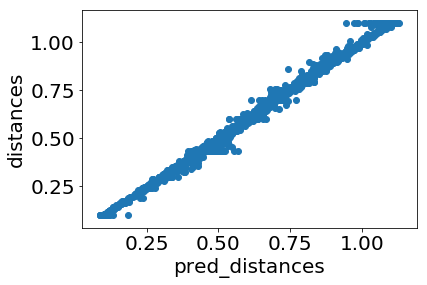

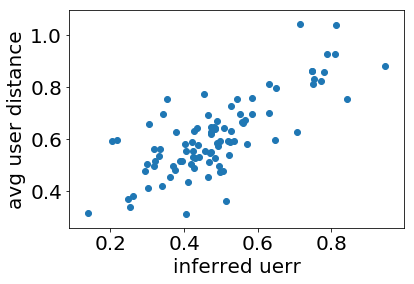

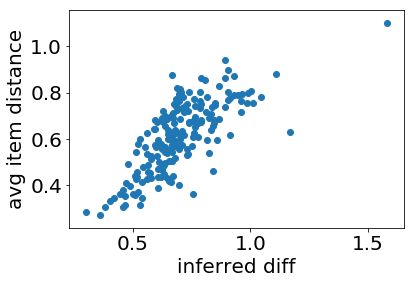

In [447]:
sequence_experiment_SS.test(debug=True)

In [438]:
sequence_experiment_SS.opt["uerr"]

array([0.21675676, 0.34260693, 0.29529934, 0.33442692, 0.77284865,
       0.29905937, 0.42542088, 0.42232366, 0.81296285, 0.47327751,
       0.33909101, 0.94673692, 0.46518278, 0.6298569 , 0.52662327,
       0.75245024, 0.47330519, 0.57186924, 0.52708936, 0.31851393,
       0.56670145, 0.40280704, 0.71560144, 0.58587015, 0.53641278,
       0.35359327, 0.37489466, 0.31766827, 0.42658841, 0.54356386,
       0.52121057, 0.78843979, 0.30477427, 0.43596331, 0.13808997,
       0.48450874, 0.65003551, 0.55668688, 0.78011937, 0.40452813,
       0.80987231, 0.25431745, 0.20483415, 0.52438347, 0.51874372,
       0.48286265, 0.74953124, 0.43790794, 0.58581416, 0.47044027,
       0.31992771, 0.49814141, 0.39529531, 0.49331818, 0.44057345,
       0.50745525, 0.8420656 , 0.41900157, 0.30309665, 0.74659909,
       0.64617007, 0.55135439, 0.4655693 , 0.45738317, 0.70704124,
       0.33271852, 0.3877225 , 0.37853761, 0.63139607, 0.24775597,
       0.48522923, 0.74705158, 0.40410364, 0.50711379, 0.42450

/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


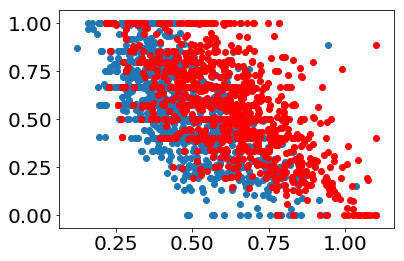


 ALL
sad -0.6272246653809628
map -0.6764851371293106


In [439]:
sequence_experiment_SS.debug(plot_vs_gold=True, skip_miniplots=True)

In [29]:
# def seq_agg_fn(idf, uerrs):
#     ulabels = {}
#     full_labelset = set()
#     uerr_denom = np.sum(np.exp(-uerrs.values))
#     for row in idf.iterrows():
#         labelset = labels2set(row[1]["label"])
#         ulabels[row[1]["uid"]] = labelset
#         full_labelset = full_labelset.union(labelset)
#     iscores = np.zeros(np.max(list(full_labelset)) + 1)
#     for i in full_labelset:
#         for u, val in ulabels.items():
#             if i in val:
#                 iscores[i] += np.exp(-uerrs[u+1]) / uerr_denom
#     result = list2ranges(np.where(iscores >= 0.5)[0])
#     return result

In [30]:
# model_agg50 = experiments.get_baseline_item_centrallest(stan_data, df, "label", "itemID", "uid",
#                                                 uerr_penalties, idiff_penalties, seq_agg_fn)

In [31]:
# model_agg = experiments.get_baseline_item_centrallest(stan_data, df, "label", "itemID", "uid",
#                                                 uerr_penalties, idiff_penalties, seq_agg_fn)

In [32]:
# experiments.eval_preds(mv_labels, model4, gold_labels, eval_f1)
# # experiments.eval_preds(ds_labels, model4, gold_labels, eval_f1)
# experiments.eval_preds(hmm_labels, model4, gold_labels, eval_f1)

In [33]:
random

{0: [[5, 44],
  [61, 135],
  [253, 294],
  [362, 421],
  [568, 580],
  [659, 859],
  [1103, 1123]],
 1: [[0, 60], [60, 769]],
 2: [[198, 218]],
 3: [[191, 257], [259, 313], [1440, 1487]],
 4: [[454, 485], [948, 972]],
 5: [[372, 406]],
 6: [[341, 435]],
 7: [[85, 108], [111, 160], [347, 388], [419, 474], [1590, 1611]],
 8: [[29, 58], [129, 177], [189, 215]],
 9: [[220, 257]],
 10: [[313, 363]],
 11: [[231, 289]],
 12: [[201, 221]],
 13: [[67, 109], [506, 514], [609, 655]],
 14: [[349, 390]],
 15: [[258, 837]],
 16: [[78, 311], [357, 368], [854, 876]],
 17: [[55, 112], [606, 617]],
 18: [[249, 389]],
 19: [[55, 100], [183, 218]],
 20: [[1071, 1225], [1426, 1465]],
 21: [[220, 293]],
 22: [[307, 415]],
 23: [[17, 33], [221, 248]],
 24: [[126, 142], [242, 268], [324, 345], [1181, 1204]],
 25: [[45, 62], [188, 224], [266, 277], [428, 465]],
 26: [[19, 36], [155, 206], [611, 641]],
 27: [[0, 98], [98, 176], [222, 276], [296, 362], [673, 696]],
 28: [[337, 361], [1973, 2012]],
 29: [[70, 98]

In [34]:
baseline

NameError: name 'baseline' is not defined

In [ ]:
model

In [ ]:
gold_labels

In [ ]:
def compare(d1, d2, g):
    result = {}
    for key, value in d1.items():
        result[str(key)+"A"] = value
    for key, value in d2.items():
        result[str(key)+"B"] = value
    for key, value in g.items():
        result[str(key)+"G"] = value
    for key in sorted(result):
        print(key, result[key])

In [ ]:
experiments.eval_preds(model_agg, model_agg50, gold_labels, eval_f1, True)